# Install the dependency for data collection

In [ ]:
!pip install yfinance ta

     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 6.4 MB 48.1 MB/s 
  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28908 sha256=2e9035ac1e01bdf26c7f4eb904a519a18970cf15a0d3a1e416cd15eb386225ca
  Stored in directory: /root/.cache/pip/wheels/72/78/64/cc1c01506a1010a9845e9bd7c69333730f7174661228ea4f98
Successfully built ta
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium=

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn import preprocessing
from ta.volatility import BollingerBands
from ta.trend import MACD
from ta.momentum import RSIIndicator
from keras.models import Sequential
from keras.layers import Conv1D,MaxPool1D,Bidirectional,LSTM,Dropout,TimeDistributed
from keras.layers import Dense,GlobalAveragePooling2D
from ta.trend import IchimokuIndicator
from sklearn.linear_model import LinearRegression
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D
from keras.layers import Dense,GlobalAveragePooling2D
import matplotlib.pyplot as plt
import yfinance as yf

# Data Pre-processing

In [ ]:
symbol = '2800.HK'#'AAPL'#'2800.HK'
stock = yf.Ticker(symbol)
df = stock.history(period="max")
stock_data = df[['Open',  'High',  'Low',  'Close', 'Volume']]

In [ ]:
indicator_bollinger = BollingerBands(close=stock_data["Close"], window=20, window_dev=2)
macd = MACD(close=stock_data["Close"])
rsi = RSIIndicator(close=stock_data["Close"])
ichi = IchimokuIndicator(high=stock_data["High"],low=stock_data["Low"])

#get the technical indicators
stock_data['macd'] = macd.macd()
stock_data['macd_signal'] = macd.macd_signal()
stock_data['rsi'] = rsi.rsi()
stock_data['bollinger_mavg'] = indicator_bollinger.bollinger_mavg()
stock_data['bollinger_hband'] = indicator_bollinger.bollinger_hband()
stock_data['bollinger_lbond'] = indicator_bollinger.bollinger_lband()
stock_data['ichimoku_a'] = ichi.ichimoku_a()
stock_data['ichimoku_b'] = ichi.ichimoku_b()
stock_data['ichimoku_base_line'] = ichi.ichimoku_base_line()
stock_data['ichimoku_conversion_line'] = ichi.ichimoku_conversion_line()
stock_data = stock_data.fillna(0)

#stock_data = stock_data[:-1]
stock_orig = stock_data.copy()

#stock = stock[250:]
stock_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Open,High,Low,Close,Volume,macd,macd_signal,rsi,bollinger_mavg,bollinger_hband,bollinger_lbond,ichimoku_a,ichimoku_b,ichimoku_base_line,ichimoku_conversion_line
Date,,,,,,,,,,,,,,,
2008-01-02,27.730000,27.730000,27.730000,27.730000,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,27.730,0.00,0.00
2008-01-03,27.059999,27.059999,27.059999,27.059999,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,27.395,0.00,0.00
2008-01-04,27.690001,27.690001,27.690001,27.690001,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,27.395,0.00,0.00
2008-01-07,27.350000,27.350000,27.350000,27.350000,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,27.395,0.00,0.00
2008-01-08,27.280001,27.280001,27.280001,27.280001,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,27.395,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-10,25.160000,25.160000,24.799999,25.040001,165812867,0.206596,0.150439,60.750844,24.471,25.265126,23.676874,24.205,23.990,24.01,24.40
2022-02-11,24.959999,25.100000,24.879999,25.020000,161166266,0.229421,0.166235,60.386143,24.529,25.305399,23.752601,24.205,23.990,24.01,24.40
2022-02-14,24.820000,24.879999,24.620001,24.680000,117839230,0.217566,0.176502,54.406696,24.538,25.317015,23.758985,24.205,23.990,24.01,24.40


# Min-Max Normalization

In [ ]:
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(stock_data.iloc[:,0:3])
stock_data.iloc[:,0:3] = scaled_values

y_scaler = preprocessing.MinMaxScaler()
scaled_values = y_scaler.fit_transform(np.array(stock_data.iloc[:,3]).reshape(-1,1))
stock_data.iloc[:,3] = scaled_values

scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(stock_data.iloc[:,4:])
stock_data.iloc[:,4:] = scaled_values


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Feature: 0 - Open, Score: -0.00749
Feature: 1 - High, Score: 0.51281
Feature: 2 - Low, Score: 0.47030
Feature: 3 - Volume, Score: -0.00024
Feature: 4 - macd, Score: -0.03628
Feature: 5 - macd_signal, Score: 0.02531
Feature: 6 - rsi, Score: 0.02859
Feature: 7 - bollinger_mavg, Score: -0.00224
Feature: 8 - bollinger_hband, Score: -0.01338
Feature: 9 - bollinger_lbond, Score: 0.01022
Feature: 10 - ichimoku_a, Score: -0.03883
Feature: 11 - ichimoku_b, Score: 0.03098
Feature: 12 - ichimoku_base_line, Score: 0.03254
Feature: 13 - ichimoku_conversion_line, Score: -0.00592


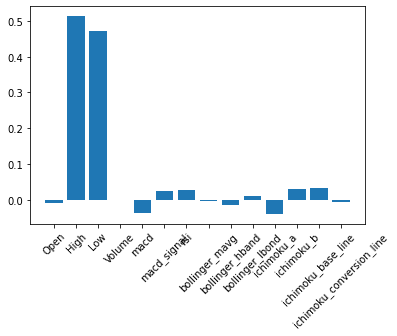

In [ ]:
L_stock = stock_data.drop(['Close'],1)
model = LinearRegression()
model.fit(L_stock.iloc[:,:], stock_data.iloc[:,3])
#model.fit(L_stock, stock_data['Close'])
importance = model.coef_
for i,v in enumerate(importance):
	print('Feature: %0d - %s, Score: %.5f' % (i,L_stock.columns[i],v))
plt.bar([L_stock.columns[x] for x in range(len(importance))], importance)
plt.xticks(rotation=45)
plt.show()

In [ ]:
#stock_final = stock.drop(['Open','Volume','macd','bb_bbm','bb_bbh','bb_bbl','ichi_a','ichi_conv'],1)
stock_final = stock_data.drop(['Open','Volume','bollinger_mavg','ichimoku_conversion_line'],1)

features = 11 #including the close price

window_size = 60
week = 7
X = []
Y = []
print(stock_final)
for i in range(0 , len(stock_data) - window_size , 1):
  X.append(np.array(stock_final.iloc[i:i+window_size,:]).reshape(window_size * features,1))
  Y.append(np.array(stock_data.iloc[i+window_size,3]).reshape(1,1))

train_X,test_X,train_label,test_label = train_test_split(X, Y, test_size=0.1,shuffle=False)
len_t = len(train_X)
# train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_label, test_size=0.2,shuffle=True)
train_X = np.array(train_X)
test_X = np.array(test_X)
train_label = np.array(train_label)
test_label = np.array(test_label)
# valid_label = np.array(valid_label)
# valid_X = np.array(valid_X)
train_X = train_X.reshape(train_X.shape[0],features,window_size,1)
test_X = test_X.reshape(test_X.shape[0],features,window_size,1)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


                High       Low  ...  ichimoku_b  ichimoku_base_line
Date                            ...                                
2008-01-02  0.729317  0.749538  ...    0.793402            0.000000
2008-01-03  0.699191  0.718577  ...    0.775284            0.000000
2008-01-04  0.727518  0.747689  ...    0.775284            0.000000
2008-01-07  0.712230  0.731978  ...    0.775284            0.000000
2008-01-08  0.709083  0.728743  ...    0.775284            0.000000
...              ...       ...  ...         ...                 ...
2022-02-10  0.613759  0.614140  ...    0.591130            0.747975
2022-02-11  0.611061  0.617837  ...    0.591130            0.747975
2022-02-14  0.601169  0.605823  ...    0.591130            0.747975
2022-02-15  0.593975  0.593808  ...    0.591130            0.747975
2022-02-17  0.607464  0.607671  ...    0.591130            0.754517

[3485 rows x 11 columns]


# Model Training

In [ ]:
model = Sequential()
#add model layers
model.add(TimeDistributed(Conv1D(128, kernel_size=1, activation='relu', input_shape=(None,50,1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(384, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(768, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200,return_sequences=False)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.fit(train_X, train_label, validation_data=(test_X,test_label), epochs=200)
print(model.summary())
print(model.evaluate(test_X,test_label))

Epoch 1/200
97/97 [==============================] - 27s 141ms/step - loss: 0.0328 - val_loss: 0.0031
Epoch 2/200
97/97 [==============================] - 8s 80ms/step - loss: 0.0045 - val_loss: 0.0020
Epoch 3/200
97/97 [==============================] - 7s 72ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 4/200
97/97 [==============================] - 7s 71ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 5/200
97/97 [==============================] - 7s 71ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 6/200
97/97 [==============================] - 7s 71ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 7/200
97/97 [==============================] - 7s 71ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 8/200
97/97 [==============================] - 7s 71ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 9/200
97/97 [==============================] - 7s 71ms/step - loss: 0.0022 - val_loss: 9.4320e-04
Epoch 10/200
97/97 [==============================] - 7s 71ms/step - loss: 0.0020 - val_loss: 

# Model Evaluation

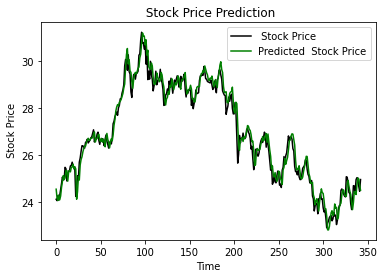

In [ ]:
predicted  = model.predict(test_X)

real_price = y_scaler.inverse_transform(test_label[:,0])
predicted = np.array(predicted[:,0]).reshape(-1,1)
predicted = y_scaler.inverse_transform(predicted)
plt.plot(real_price, color = 'black', label = ' Stock Price')
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

# Make the price prediction for next day

In [ ]:
x_pred = []
x_pred.append(np.array(stock_final.iloc[-window_size:,:]).reshape(window_size * features,1))
x_pred = np.array(x_pred)
x_pred = x_pred.reshape(x_pred.shape[0],features,window_size,1)
next_price  = model.predict(x_pred)
next_price = np.array(next_price[:,0]).reshape(-1,1)
next_price = y_scaler.inverse_transform(next_price)
next_price[0][0]

24.827562

In [ ]:
train_X,test_X,train_label,test_label = train_test_split(X, Y, test_size=0.1,shuffle=False)

# Save the Model

In [ ]:
model.save('lstm-cnn.h5')

In [ ]:
# from google.colab import files
# files.download('lstm-cnn.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>